Loading all the required packages!

In [1]:
#!pip install skforecast
# Data processing
# ==============================================================================
import os
import pandas as pd
import numpy as np

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

# Time series modeling
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold,  OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.model_selection import TimeSeriesFold
from skforecast.preprocessing import RollingFeatures

2024-12-29 19:04:32.705322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the dataset and making a copy

In [2]:
df1 = pd.read_excel('/Users/christianhellum/Cand. Merc./Data-Science-Project/data_science_project/Praktik/data_final.xlsx')

In [3]:
df = df1.copy()
#drop missing data
df = df.dropna()

A bit of feature engineering - Deleting all negative values and making rolling mean features

In [4]:
# Initially include all rows
df["Include"] = True

# Function to tag rows based on conditions
def tag_abnormal_values(df, condition, include_col='Include'):
    """
    Updates the Include column to False for rows that satisfy the given condition.

    :param df: The DataFrame to modify.
    :param condition: A condition (boolean array or series) for abnormal values.
    :param include_col: The column name to update for inclusion.
    :return: Modified DataFrame with updated Include column.
    """
    df.loc[condition, include_col] = False
    return df

# Define conditions for abnormality
conditions = [
    (df['energy_total'] < 1) | (df['energy_total'] > 2800)
]

# Exclude abnormal features
for condition in conditions:
    df = tag_abnormal_values(df, condition)
# Cut out all abnormal values
df = df[df.Include].drop(["Include"], axis=1)

#delete columns 'dhi', 'dni', 'precip', 'snow', 'wind_spd'
df = df.drop(['dhi', 'dni', 'precip', 'snow', 'wind_spd'], axis=1)

#extract the hour from the datetime column
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

#only keep rows where hour is between 8 and 18
df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
#delete three first rows
df = df.iloc[3:]

#drop hour column
df = df.drop(['hour'], axis=1)
df = df.drop(['hour_nr'], axis=1)
df = df.drop(['day_of_year'], axis=1)
df = df.drop(['month_nr'], axis=1)

#start the data from date 2022-03-30 08:00:00
df = df[df['datetime'] >= '2022-03-30 08:00:00']

#delete energy_total in df
df = df.drop(columns=['datetime'], axis=1)

Box-cox transforming our target variable 'energy_total' because it is the transformation closest to a normal distribution

In [86]:
#box cox transformation of energy_total
from scipy.stats import boxcox
df['energy_total'], lmbda = boxcox(df['energy_total'])

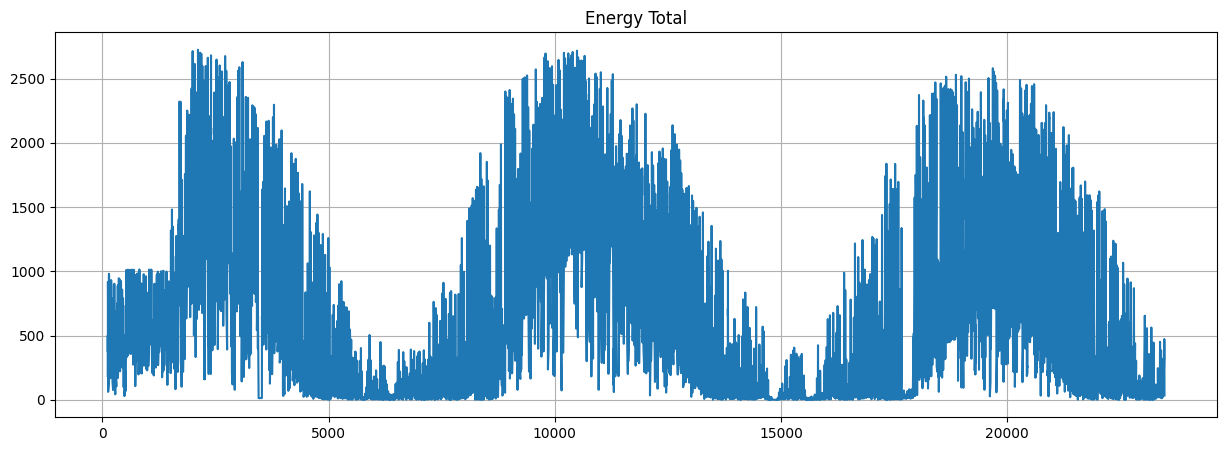

In [5]:
#plot the transformed data energy total
plt.figure(figsize=(15, 5))
plt.plot(df['energy_total'])
plt.title('Energy Total')
plt.grid(True)
plt.show()

Indexing the data before splitting into 75%, 15% and 5%

In [6]:
df.reset_index(drop=True, inplace=True)  # Use RangeIndex

train_end = int(0.75 * len(df))
val_end = train_end + int(0.15 * len(df))

df_train = df.iloc[:train_end, :].copy()
df_val = df.iloc[train_end:val_end, :].copy()
df_test = df.iloc[val_end:, :].copy()

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 7322
Validation size: 1464
Test size: 977


In [89]:
# Calculate mean and standard deviation for all features except 'energy_total'
features_to_scale = [col for col in df_train.columns if col != 'energy_total']
train_mean = df_train[features_to_scale].mean()
train_std = df_train[features_to_scale].std()

# Scale the selected features
df_train[features_to_scale] = (df_train[features_to_scale] - train_mean) / train_std
df_val[features_to_scale] = (df_val[features_to_scale] - train_mean) / train_std
df_test[features_to_scale] = (df_test[features_to_scale] - train_mean) / train_std
df[features_to_scale] = (df[features_to_scale] - train_mean) / train_std

Before running our models lets check for stationarity. 

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df_train['energy_total'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

A p-value of below 0.05 and a large negative number for the ADF statistic indicates stationarity in our dataset. That makes great sense since it is depenedent on weather features. That is pretty much the same every year. We do not need to do anything from here

1. model is the simple moving average model, which does great in general. This is the model we want be better than. We will compare the MAE of each model on validation and test set

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function for Exponential Smoothing
def exponential_smoothing(series, alpha):
    """
    Apply exponential smoothing to a time series.
    
    Args:
        series (array-like): The input time series data.
        alpha (float): Smoothing factor (0 < alpha <= 1).
    
    Returns:
        numpy array: Smoothed series.
    """
    smoothed = [series[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed.append(alpha * series[t] + (1 - alpha) * smoothed[-1])
    return np.array(smoothed)

# Define the alpha for exponential smoothing (1/window_size)
window_size = 20
alpha = 1 / window_size

# Extract the `energy_total` column
train_series = df_train['energy_total'].to_numpy()
val_series = df_val['energy_total'].to_numpy()
test_series = df_test['energy_total'].to_numpy()

# Combine all series for smoothing
combined_series = np.concatenate([train_series, val_series, test_series])

# Apply exponential smoothing
smoothed_series = exponential_smoothing(combined_series, alpha)

# Extract forecasts for validation and test sets
val_start_index = len(train_series)
val_end_index = val_start_index + len(val_series)
test_start_index = val_end_index

val_forecast = smoothed_series[val_start_index:val_end_index]
test_forecast = smoothed_series[test_start_index:test_start_index + len(test_series)]

# Evaluate on validation and test sets
val_mae = mean_absolute_error(val_series, val_forecast)
test_mae = mean_absolute_error(test_series, test_forecast)

print(f"Validation MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Plotting the test set predictions and the actual values

In [ ]:
# Plot test set predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, test_series, label='Actual Values', marker='o', linestyle='-')
plt.plot(df_test.index, test_forecast, label='Predicted Values (Exponential Smoothing)', marker='x', linestyle='--')
plt.title('Test Set: Actual vs Predicted Values (Exponential Smoothing)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Total', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

2. Second model is getting more complex. It is now XGBoost turn to show how it's done. We start of by defining the window that should be relevant to predict the next 10 values of the energy production

In [133]:
window_features = RollingFeatures(stats=["mean"], window_sizes=20)

In [ ]:
df.columns

We define the exogenous variables

In [137]:
exog_features = ['clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'sine_elevation', 'cosine_elevation',
       'sine_azimuth', 'cosine_azimuth']

We also lag the target feature by 30 hours back (3 days)

In [138]:
from xgboost import XGBRegressor
# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = XGBRegressor(tree_method='hist', enable_categorical=True, random_state=123),
    lags = 20,
    window_features  = window_features
)

We do a hyperparameter search to get the best model on a CPU

In [ ]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [20]

# Folds used for the hyperparameter search and backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(df_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 10,
                    initial_train_size = len(df[:val_end]),
                    refit              = False,
                 )
# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = df.loc[:val_end, 'energy_total'],
    exog          = df.loc[:val_end, exog_features],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

In [ ]:
forecaster

Then we backtest the model on the test data

In [ ]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_xgboost, predictions = backtesting_forecaster(
    forecaster    = forecaster,
    y             = df['energy_total'],
    exog          = df[exog_features],
    cv            = cv_backtesting,
    metric        = 'mean_absolute_error',
    n_jobs        = 'auto',
    verbose       = False,
)
metric_xgboost

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs real value
plt.figure(figsize=(12, 8))  # Size in inches (750x350 pixels ≈ 7.5x3.5 inches)

# Plot real values
plt.plot(df_test.index, df_test['energy_total'], label="Test", linestyle='-', linewidth=1)

# Plot predictions
plt.plot(predictions.index, predictions['pred'], label="Prediction", linestyle='-', linewidth=1)

# Title and axis labels
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Add legend
plt.legend(loc="upper left", bbox_to_anchor=(0.001, 1.1), ncol=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
df.columns

In [7]:
# Creación del modelo
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv',
       'energy_total', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'sine_elevation', 'cosine_elevation',
       'sine_azimuth', 'cosine_azimuth'] 
levels = ["energy_total"] 
lags = 20 
steps = 10 

data = df[series].copy()
data_train = df_train[series].copy()
data_val = df_val[series].copy()
data_test = df_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.3.3
Using backend: tensorflow
tensorflow version: 2.16.1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 100)        │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,530 (330.20 KB)

 Trainable params: 84,530 (330.20 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    fit_kwargs={
        "epochs": 20,  
        "batch_size": 64,  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_1, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for series: MinMaxScaler() 
Window size: 20 
Target series, levels: ['energy_total'] 
Multivariate series (names): None 
Maximum steps predicted: [ 1  2  3  4  5  6  7  8  9 10] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 20, 18), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'relu'

In [9]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.2949 - val_loss: 0.0674
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0313 - val_loss: 0.0656
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0296 - val_loss: 0.0652
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0277 - val_loss: 0.0555
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0218 - val_loss: 0.0474
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0185 - val_loss: 0.0482
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0174 - val_loss: 0.0504
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0166 - val_loss: 0.0451
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0165 - val_loss: 0.0477
Epoch 10/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0159 - val_loss: 0.0465
Epoch 11/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0166 - val_loss: 0.0475
Epoch 12/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,energy_total
7322,234.242935
7323,288.791077
7324,279.115540
7325,235.381790
7326,147.895935
7327,142.842163
7328,165.318054
7329,212.383759
7330,217.868622
7331,242.599609


In [11]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
        steps=forecaster.max_step,
        initial_train_size=len(data.loc[:val_end, :]),
        refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0194 - val_loss: 0.0486
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0192 - val_loss: 0.0408
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0184 - val_loss: 0.0395
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0177 - val_loss: 0.0432
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0179 - val_loss: 0.0428
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0180 - val_loss: 0.0413
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0176 - val_loss: 0.0425
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0180 - val_loss: 0.0403
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0177 - val_loss: 0.0435
Epoch 10/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0181 - val_loss: 0.0433
Epoch 11/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0176 - val_loss: 0.0391
Epoch 12/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/98 [00:00<?, ?it/s]

In [12]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["energy_total"])
print(f"Serie mean: {np.mean(data['energy_total']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 824.69
Relative error (mae): 48.30 %


In [13]:
metrics

,levels,mean_absolute_error
0,energy_total,398.3519


In [14]:
# Backtesting predictions
# ==============================================================================
predictions

,energy_total
8787,1322.677979
8788,1101.731812
8789,859.728943
8790,659.933594
8791,479.388824
...,...
9758,-555.928833
9759,-425.175476
9760,-57.184444
9761,601.367737


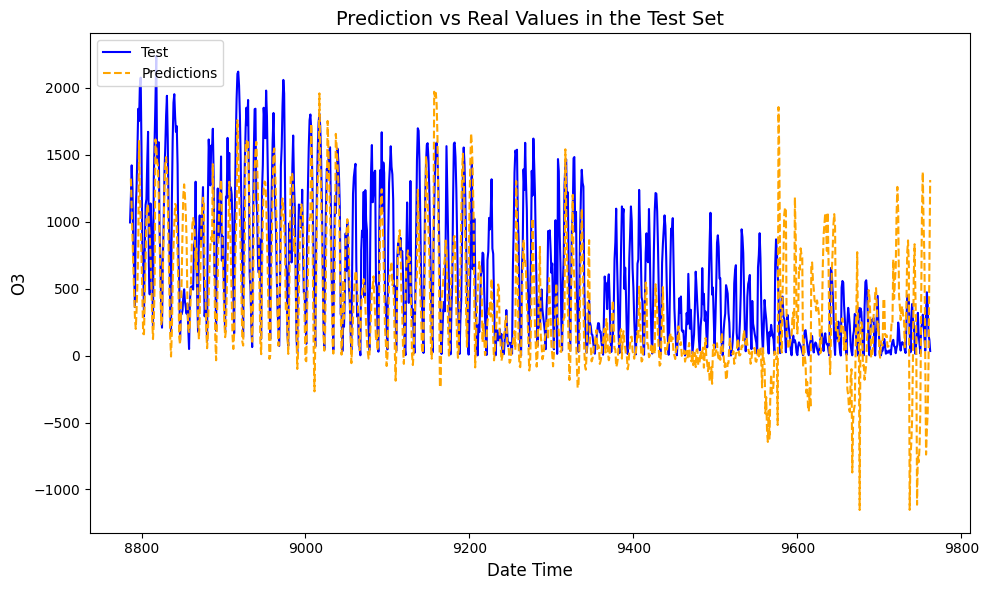

In [15]:
import matplotlib.pyplot as plt

# Plotting predictions vs real values in the test set
plt.figure(figsize=(10, 6))

# Plot test values
plt.plot(data_test.index, data_test['energy_total'], label='Test', linestyle='-', color='blue')

# Plot predictions
plt.plot(predictions.index, predictions['energy_total'], label='Predictions', linestyle='--', color='orange')

# Add title and labels
plt.title('Prediction vs Real Values in the Test Set', fontsize=14)
plt.xlabel('Date Time', fontsize=12)
plt.ylabel('O3', fontsize=12)

# Add legend
plt.legend(loc='upper left', fontsize=10)

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()